In [1]:
# import module
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [2]:
# set scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)
%matplotlib inline

### load data

In [26]:
raw_data = pd.read_csv('./input/mRNA_luad_cancer_selected_features_with_stage.txt', index_col=0)
DEG = pd.read_csv('./input/marker gene--DEG.csv', index_col=0)
ID_Symbol = pd.read_csv('./input/ID-Symbol.csv', usecols=['SYMBOL', 'ENTREZID'])

### data prepare

In [30]:
# set index and drop redundance columns
data_matrix = raw_data.set_index('SAMPLE_ID').drop(columns=['CANCER', 'AJCC_PATHOLOGIC_TUMOR_STAGE'])
# fill NA with zero
data_matrix.fillna(0.0, inplace=True)

- build observations data

In [31]:
observations = pd.DataFrame([data_matrix.index.str[:12], data_matrix.index.str[:7].astype('category')], index=['patient', 'patient_group'], columns=data_matrix.index).T

- build variables data

In [32]:
# filter gene ID
variables = ID_Symbol[ID_Symbol['SYMBOL'].isin(data_matrix.columns)]
# delete duplicate gene symbol
variables.drop_duplicates(subset=['SYMBOL'], keep='first', inplace=True)
# set index
variables.index = [str(i) for i in range(1, variables.shape[0] + 1)]

D:\Anaconda3\envs\Scanpy\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


- get marker gene

In [33]:
# filter top 12 logFC differential expression gene
marker_gene = DEG.iloc[0:12, :]
marker_gene_ID = variables[variables['SYMBOL'].isin(marker_gene.index)]

### Exploratory data analysis

In [34]:
# match matrix columns with gene
data_matrix = data_matrix[variables['SYMBOL']]
data_matrix.columns = variables.index

In [35]:
# build annotation data
adata = sc.AnnData(X=data_matrix, obs=observations, var=variables)

In [36]:
print(adata.var)

     ENTREZID  SYMBOL
1          25    ABL1
2          27    ABL2
3          60    ACTB
4          71   ACTG1
5          90   ACVR1
..        ...     ...
956    340419   RSPO2
957    340602   EZHIP
958    345930   ECT2L
959    387923   SERP2
960    399687  MYO18A

[960 rows x 2 columns]


In [37]:
print(adata.obs)

                      patient patient_group
SAMPLE_ID                                  
TCGA-05-4244-01  TCGA-05-4244       TCGA-05
TCGA-05-4249-01  TCGA-05-4249       TCGA-05
TCGA-05-4250-01  TCGA-05-4250       TCGA-05
TCGA-05-4382-01  TCGA-05-4382       TCGA-05
TCGA-05-4384-01  TCGA-05-4384       TCGA-05
...                       ...           ...
TCGA-NJ-A55O-01  TCGA-NJ-A55O       TCGA-NJ
TCGA-NJ-A55R-01  TCGA-NJ-A55R       TCGA-NJ
TCGA-NJ-A7XG-01  TCGA-NJ-A7XG       TCGA-NJ
TCGA-O1-A52J-01  TCGA-O1-A52J       TCGA-O1
TCGA-S2-AA1A-01  TCGA-S2-AA1A       TCGA-S2

[510 rows x 2 columns]


In [38]:
print(adata.X)

[[-1.9591  1.6313  0.5723 ... -0.0405 -1.2213  0.3024]
 [ 0.5516  1.3186 -0.8968 ... -0.2158 -1.5792  0.8419]
 [-1.9813  1.2359  1.6222 ... -1.3064  1.0311  1.4816]
 ...
 [-0.701   0.1704 -2.0314 ... -1.6756  2.357   0.1992]
 [-0.4558  1.0674  1.5455 ... -1.712  -4.0105  2.3515]
 [-0.7032  0.0295 -1.7037 ... -0.7511 -0.402   2.5712]]


In [39]:
print(adata.obs['patient'].value_counts())

TCGA-05-4244    1
TCGA-78-7153    1
TCGA-78-7535    1
TCGA-78-7220    1
TCGA-78-7167    1
               ..
TCGA-55-6971    1
TCGA-55-6970    1
TCGA-55-6969    1
TCGA-55-6968    1
TCGA-S2-AA1A    1
Name: patient, Length: 510, dtype: int64


In [40]:
print(adata.var_names)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '951', '952', '953', '954', '955', '956', '957', '958', '959', '960'],
      dtype='object', length=960)


In [41]:
# mitochondrial genes
adata.var['mt'] = adata.var['SYMBOL'].str.startswith('MT-')
# ribosomal genes
adata.var['ribo'] = adata.var['SYMBOL'].str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var['SYMBOL'].str.contains(("^HB[^(P)]"))
adata.var.fillna({'mt': False, 'ribo': False, 'hb': False}, inplace=True)

In [42]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)

In [43]:
print(adata.obs)
print(adata.obs['total_counts'])

                      patient patient_group  n_genes_by_counts  total_counts  \
SAMPLE_ID                                                                      
TCGA-05-4244-01  TCGA-05-4244       TCGA-05                960   -180.711060   
TCGA-05-4249-01  TCGA-05-4249       TCGA-05                960    357.444000   
TCGA-05-4250-01  TCGA-05-4250       TCGA-05                960    -58.186916   
TCGA-05-4382-01  TCGA-05-4382       TCGA-05                960    252.203262   
TCGA-05-4384-01  TCGA-05-4384       TCGA-05                960     18.138481   
...                       ...           ...                ...           ...   
TCGA-NJ-A55O-01  TCGA-NJ-A55O       TCGA-NJ                960   -135.599518   
TCGA-NJ-A55R-01  TCGA-NJ-A55R       TCGA-NJ                960      1.103969   
TCGA-NJ-A7XG-01  TCGA-NJ-A7XG       TCGA-NJ                960   -598.122559   
TCGA-O1-A52J-01  TCGA-O1-A52J       TCGA-O1                960   -263.028351   
TCGA-S2-AA1A-01  TCGA-S2-AA1A       TCGA

- visualization

D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient_group' as categorical


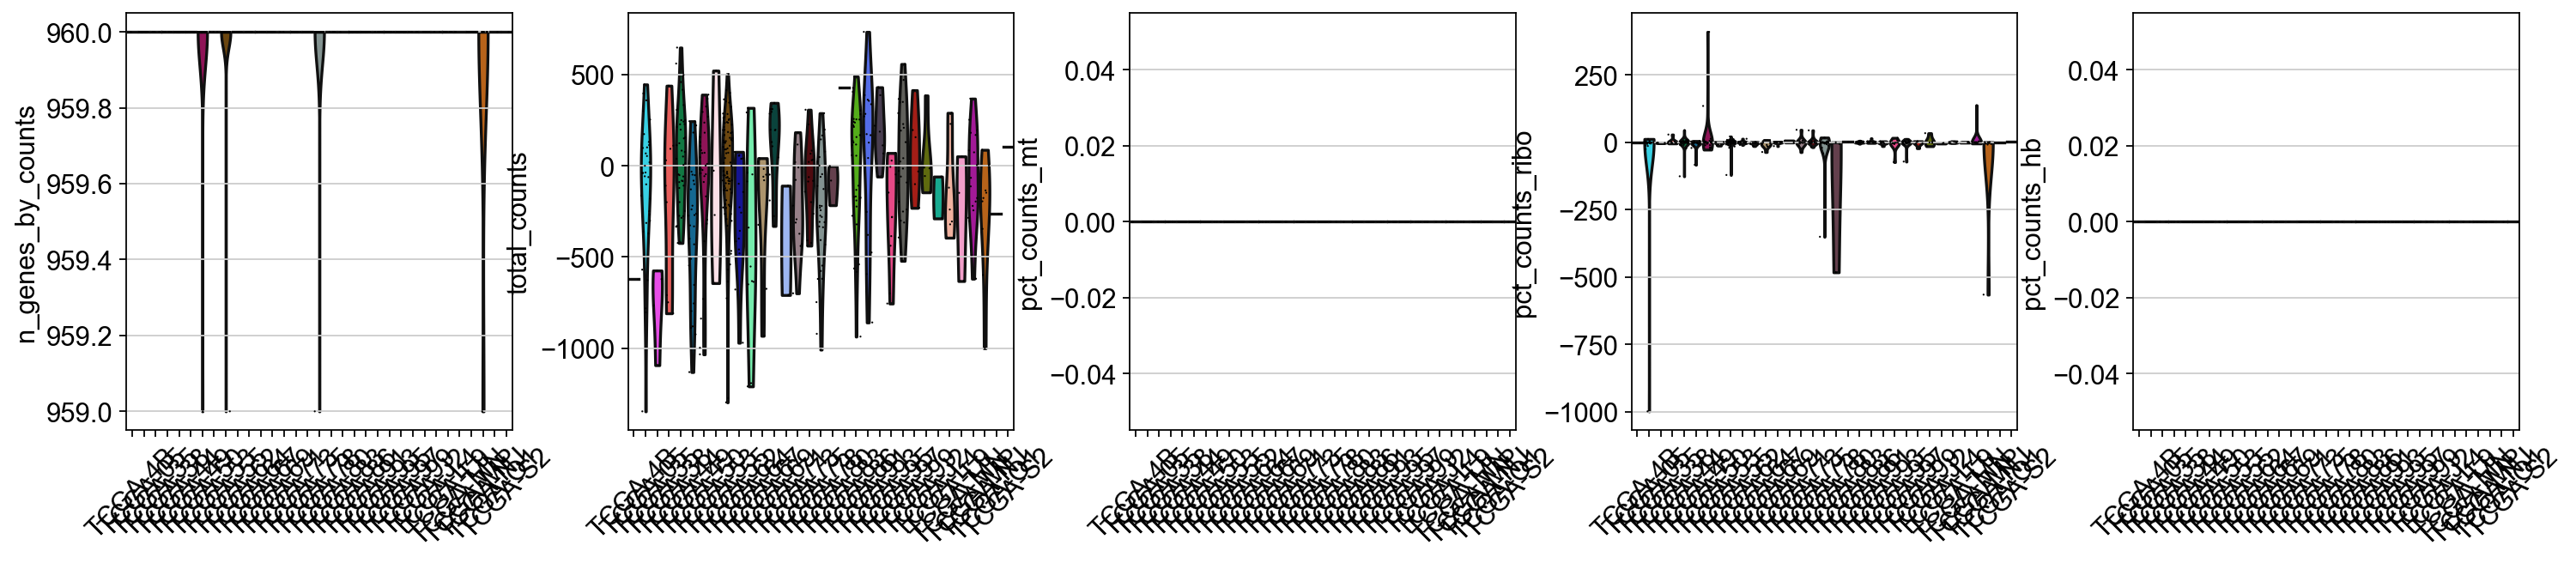

In [28]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, groupby='patient_group', rotation=45)

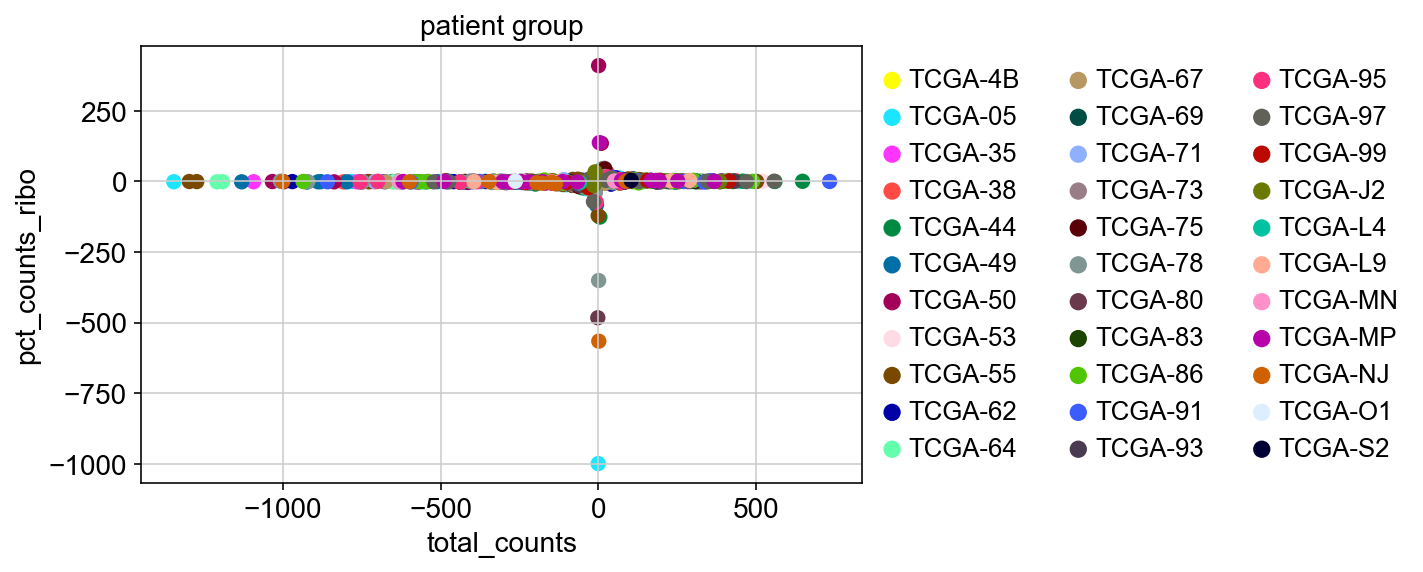

In [60]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="patient_group")

In [31]:
print(adata.n_obs, adata.n_vars)

510 960


normalizing counts per cell
    finished (0:00:00)


D:\Anaconda3\envs\WGS\lib\site-packages\scanpy\preprocessing\_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


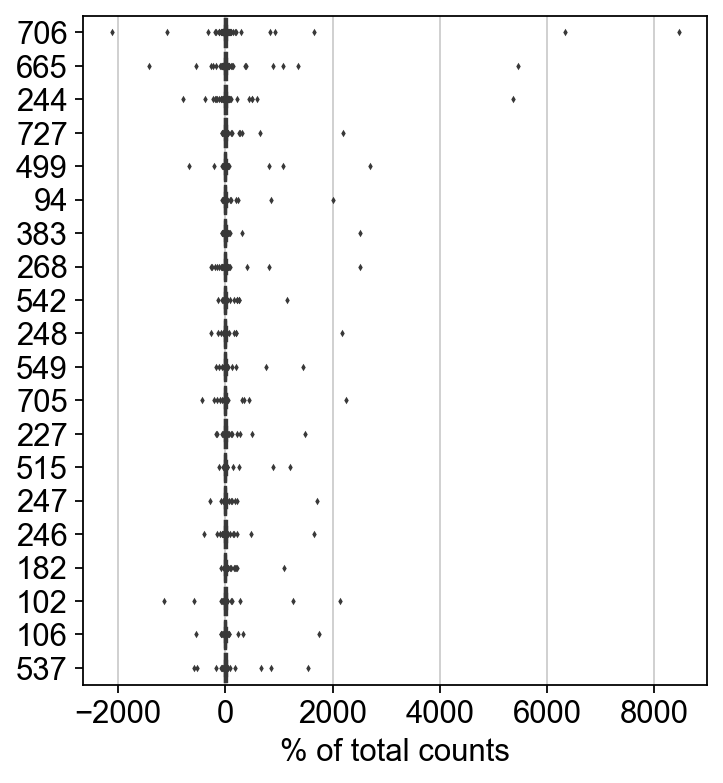

In [32]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [33]:
print(adata.var.loc[['159']])

     ENTREZID SYMBOL     mt   ribo     hb  n_cells_by_counts  mean_counts  \
159      2066  ERBB4  False  False  False                510    -5.063125   

     pct_dropout_by_counts  total_counts  
159                    0.0  -2582.193604  


In [34]:
print(adata.var.loc[['291']])

     ENTREZID SYMBOL     mt   ribo     hb  n_cells_by_counts  mean_counts  \
291      3845   KRAS  False  False  False                510      1.73382   

     pct_dropout_by_counts  total_counts  
291                    0.0    884.248047  


- PCA

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [36]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [37]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


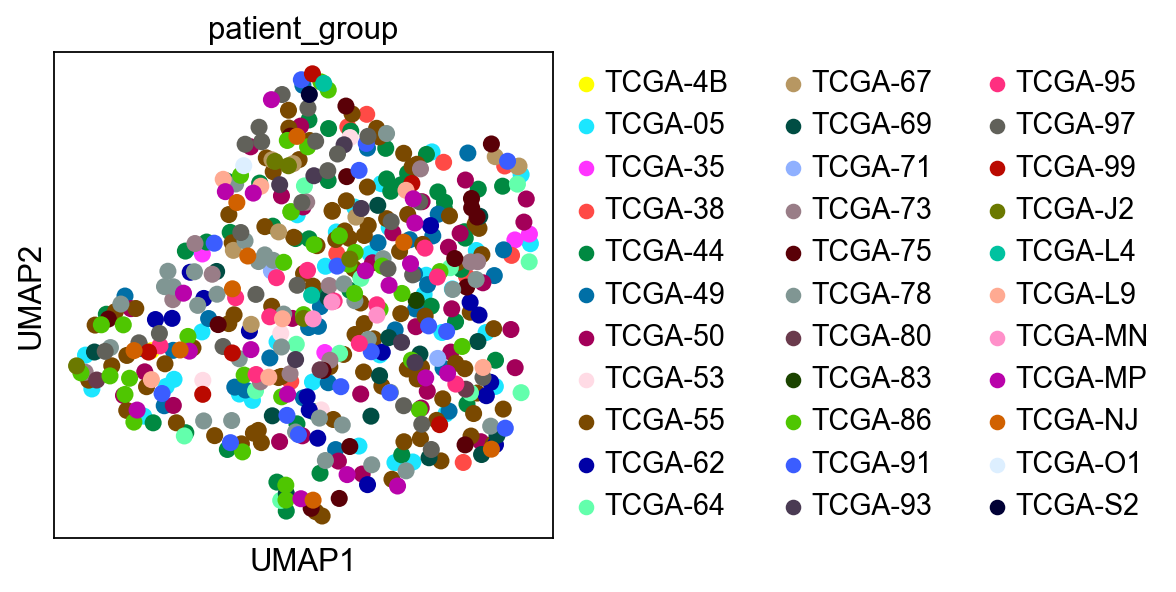

In [38]:
# it would be great to color by cancer, cancer stage, etc (requires connecting the data sets)
# This is applicable to the rest of the visualizations
sc.pl.umap(adata, color=['patient_group'])

In [39]:
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE


D:\Anaconda3\envs\WGS\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)


In [40]:
# save to file
save_file = './output/mRNA-samples.h5ad'
adata.write_h5ad(save_file)

### Cluster by scanpy

In [42]:
# select the data
input_file = './output/mRNA-samples.h5ad'
adata = sc.read_h5ad(input_file)

In [43]:
sc.tl.leiden(adata, key_added="leiden_1.0")  # default resolution in 1.0
sc.tl.leiden(adata, resolution=0.6, key_added="leiden_0.6")
sc.tl.leiden(adata, resolution=0.4, key_added="leiden_0.4")
sc.tl.leiden(adata, resolution=1.4, key_added="leiden_1.4")

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


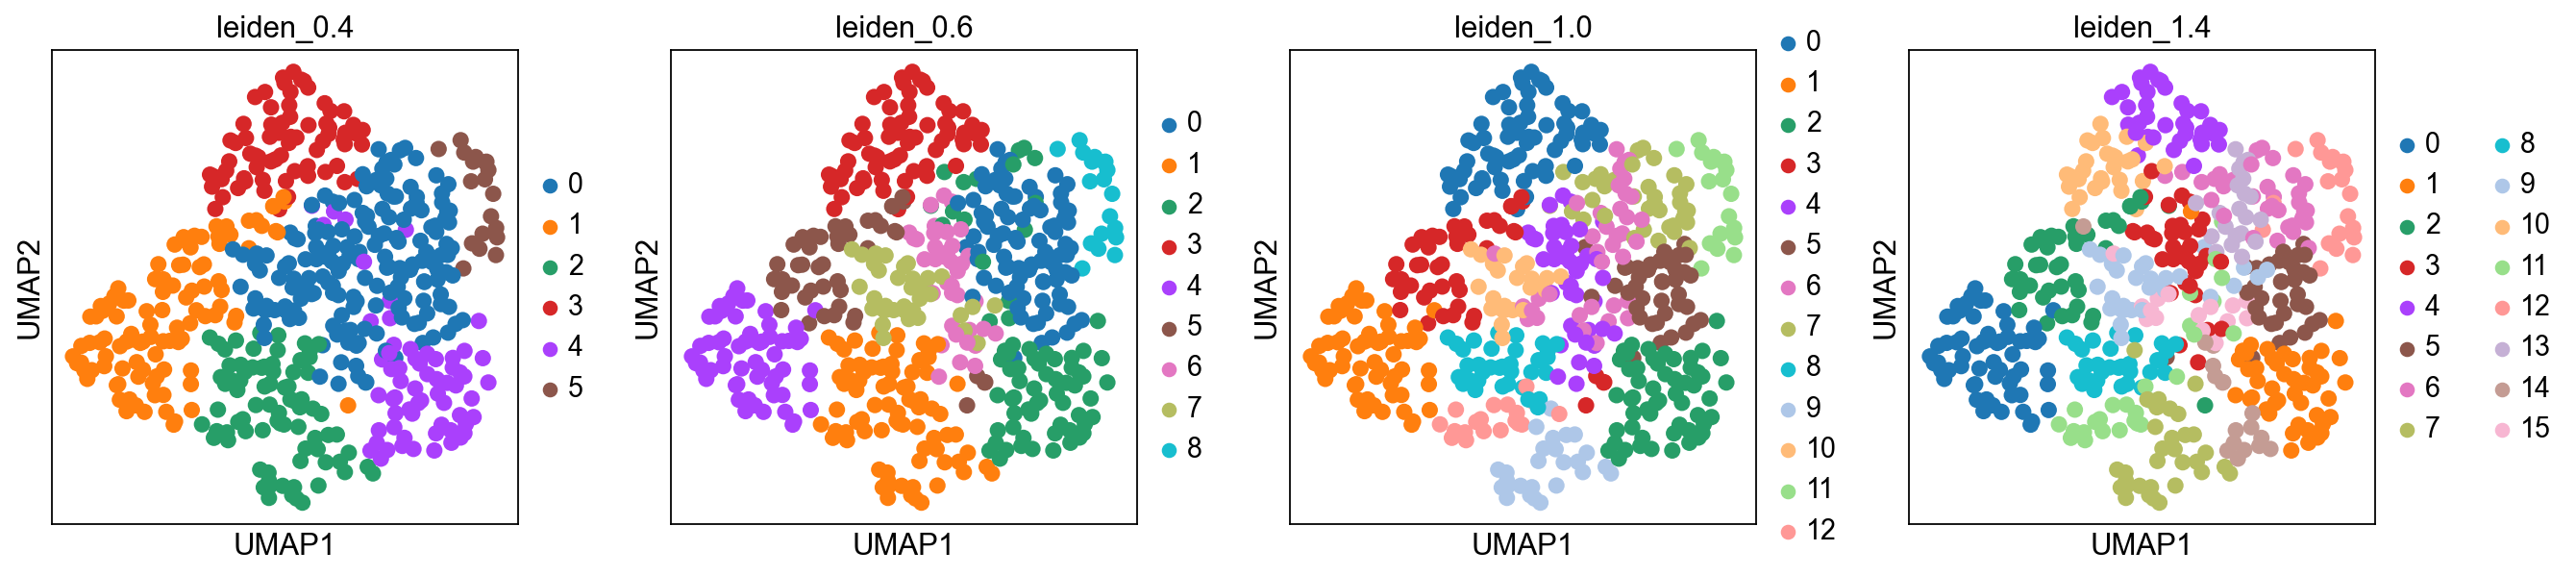

In [44]:
sc.pl.umap(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4'])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.6']`


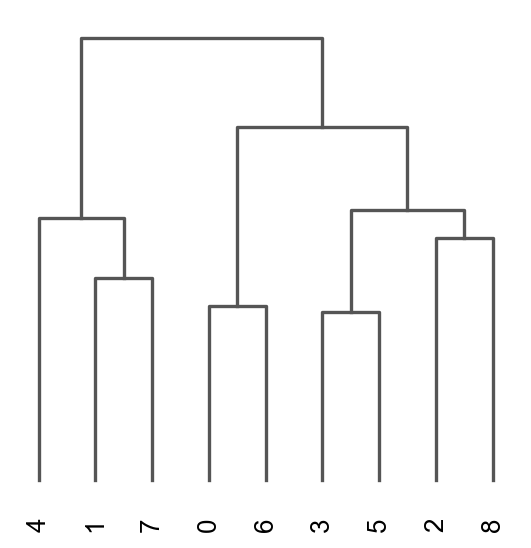

<AxesSubplot:>

In [45]:
sc.tl.dendrogram(adata, groupby="leiden_0.6")
sc.pl.dendrogram(adata, groupby="leiden_0.6")

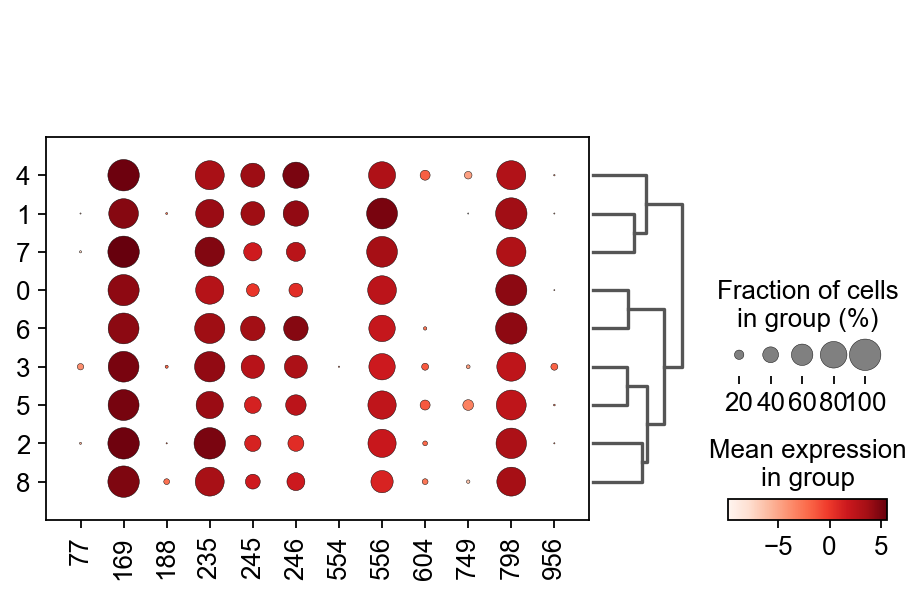

In [46]:
genes = marker_gene_ID['ENTREZID'].index
sc.pl.dotplot(adata, genes, groupby='leiden_0.6', dendrogram=True)

<AxesSubplot:xlabel='leiden_0.6'>

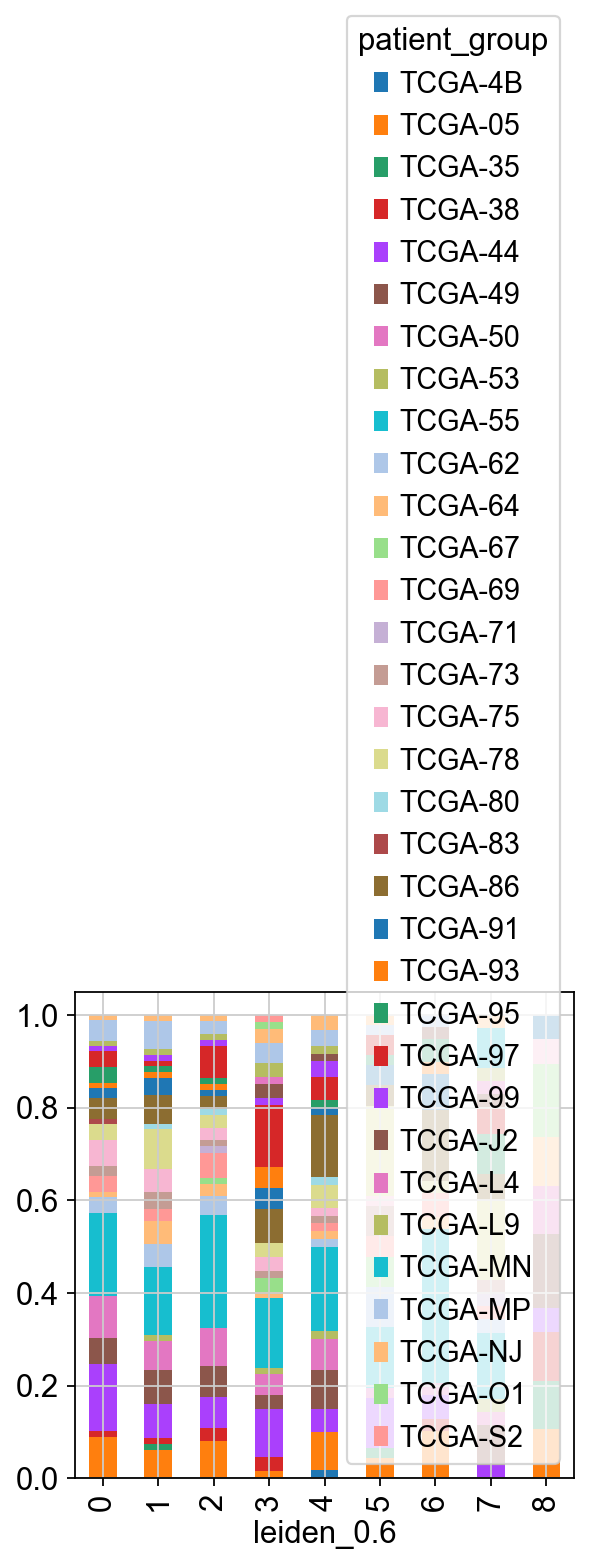

In [47]:
tmp = pd.crosstab(adata.obs['leiden_0.6'], adata.obs['patient_group'], normalize='index')
tmp.plot.bar(stacked=True)  # .legend(loc='lower right')

In [48]:
sc.tl.leiden(adata, key_added="louvain_1.0")  # default resolution is 1.0
sc.tl.leiden(adata, resolution=0.6, key_added="louvain_0.6")
sc.tl.leiden(adata, resolution=0.4, key_added="louvain_0.4")
sc.tl.leiden(adata, resolution=1.4, key_added="louvain_1.4")

running Leiden clustering
    finished: found 13 clusters and added
    'louvain_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'louvain_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'louvain_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'louvain_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


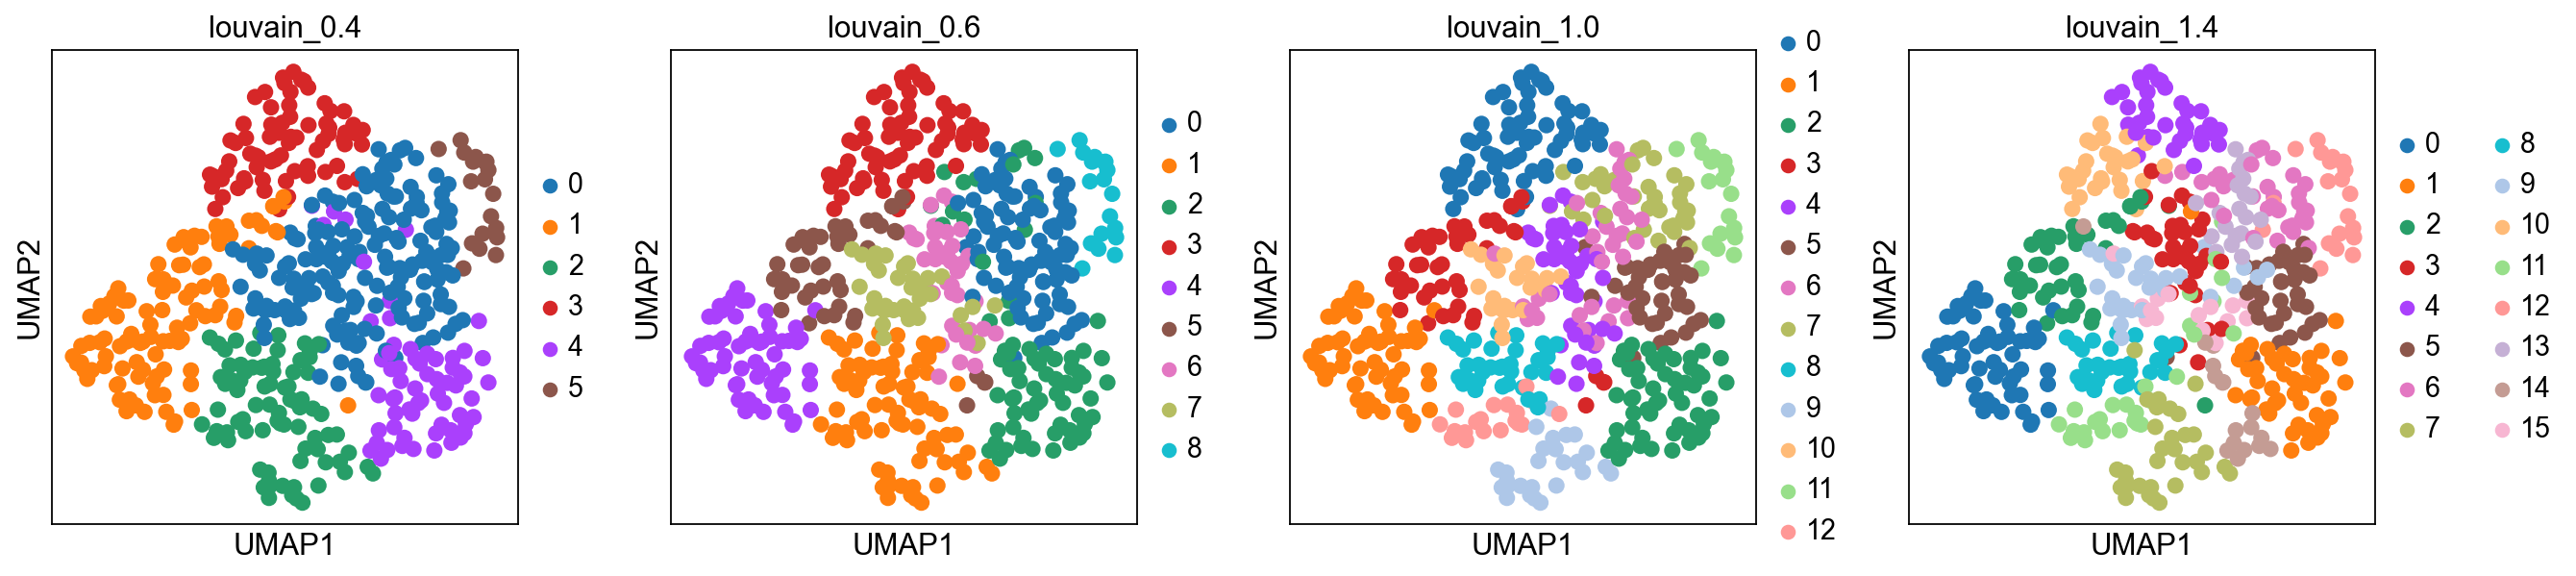

In [49]:
sc.pl.umap(adata, color=['louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4'])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain_0.6']`


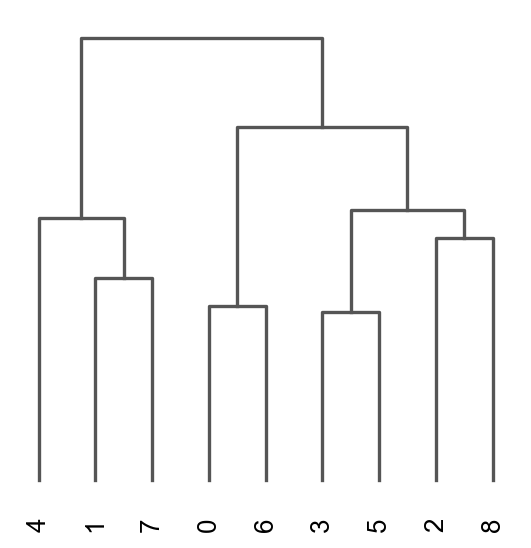

<AxesSubplot:>

In [50]:
sc.tl.dendrogram(adata, groupby="louvain_0.6")
sc.pl.dendrogram(adata, groupby="louvain_0.6")

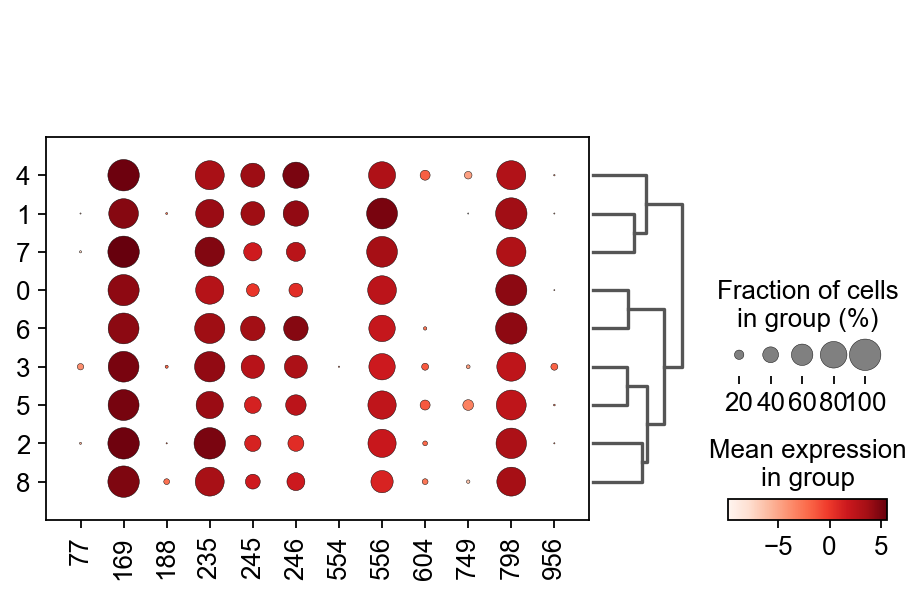

In [51]:
genes = marker_gene_ID['ENTREZID'].index

sc.pl.dotplot(adata, genes, groupby='louvain_0.6', dendrogram=True)

- K-means clustering

In [52]:
# extract pca coordinates
X_pca = adata.obsm['X_pca']

In [53]:
# kmeans with k=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca)
adata.obs['kmeans5'] = kmeans.labels_.astype(str)

In [54]:
# kmeans with k=10
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca)
adata.obs['kmeans10'] = kmeans.labels_.astype(str)

D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans5' as categorical
D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans10' as categorical
D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Ca

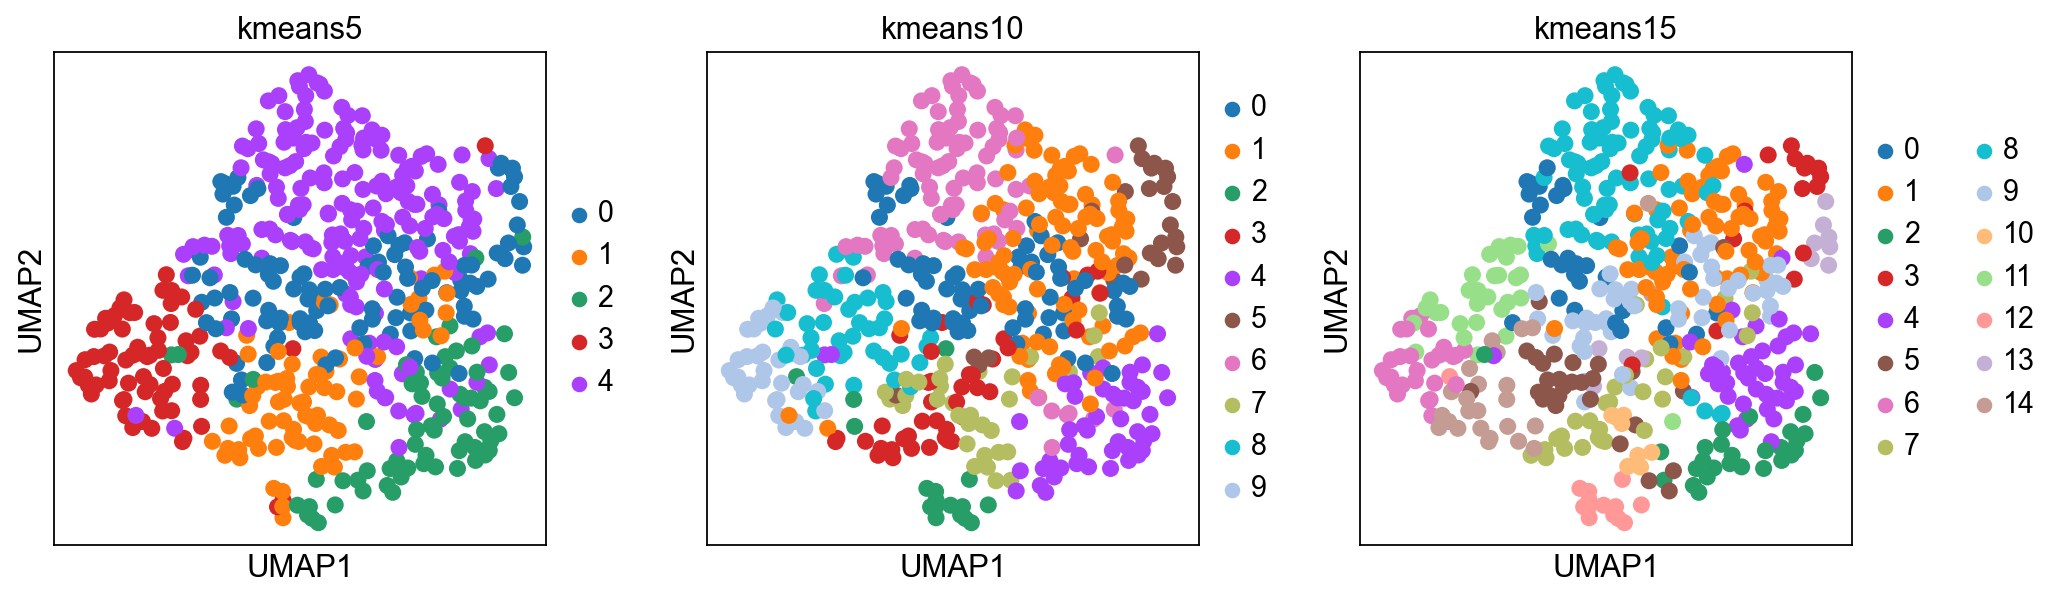

In [55]:
# kmeans with k=15
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_pca)
adata.obs['kmeans15'] = kmeans.labels_.astype(str)

sc.pl.umap(adata, color=['kmeans5', 'kmeans10', 'kmeans15'])

In [56]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
adata.obs['hclust_5'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
adata.obs['hclust_10'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='ward')
adata.obs['hclust_15'] = cluster.fit_predict(X_pca).astype(str)

D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hclust_5' as categorical
D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hclust_10' as categorical
D:\Anaconda3\envs\WGS\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new 

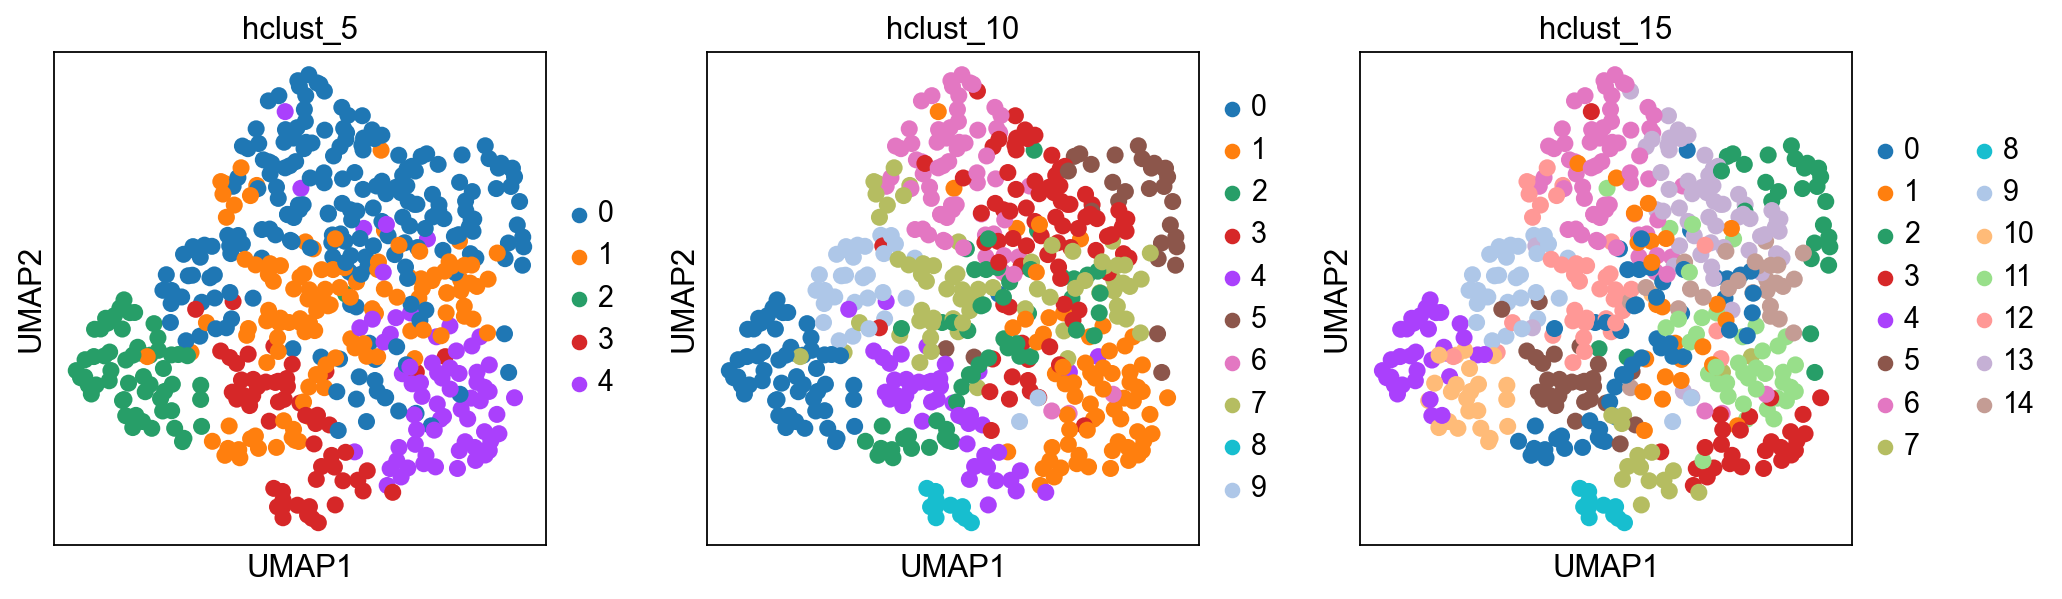

In [57]:
sc.pl.umap(adata, color=['hclust_5', 'hclust_10', 'hclust_15'])

In [58]:
adata.write_h5ad('./output/clustered_set.h5ad')